# Pneumonia Detection

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pathlib as Path
import os

In [6]:
gpu = False

# verify if GPU parallel calculus is possible
if(torch.cuda.is_available()):
    print(f"GPU available: {torch.cuda.get_device_name()}")
    gpu = True
else:
    print("No GPU available")

GPU available: NVIDIA GeForce RTX 5050 Laptop GPU


In [7]:
import shutil
import kagglehub

dataset_url = "paultimothymooney/chest-xray-pneumonia"
DATA_DIR = "chest_xray/chest_xray"

def load_data():
    """
    Load original pneumonia images data from the Kaggle's dataset. 
    """
    # if it finds the data does nothing otherwise it installs it --> cannot pass the dataset to Github for dimension limitations
    if os.path.exists(DATA_DIR):
        print(f"Data found in {DATA_DIR}")
    else:
        # Download latest version --> kagglehub stores the dataset in a sort of cached memory so you need to copy it in local
        path = kagglehub.dataset_download(dataset_url)
        
        shutil.copytree(path, ".", dirs_exist_ok=True)

        print("Path to dataset files:", path)
        
load_data()

Data found in chest_xray/chest_xray


/home/tgrimaldi/polimi/NAML/Pneumonia_Detection-NAML_25-26/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

RESIZE_IMG = (128, 128) # resize img from (224,224) -> (128, 128)
datasets_names = ["train", "val", "test"]

# we create a set of transformations -> operations that will be applied to each img of the dataset for preprocessing
data_transforms = {
    x: transforms.Compose([
        transforms.Resize(RESIZE_IMG), # resizes the image to the desired dimension
        transforms.Grayscale(num_output_channels=3), # the paper uses three channels for these images
        transforms.ToTensor(), # convert all the values from range [0, 255] -> [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], # Standard ImageNet normalization
                             [0.229, 0.224, 0.225]) # a quanto pare sono valori standardizzati usati per trainare modelli (si potrebbe pensare di rimuoverli)
    ]) for x in datasets_names
}

# build a dictionary with three keys for each dataset we have (train, val, test)
# it also applies the transformations defined before
image_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in datasets_names
}

class_names = image_datasets["train"].classes
print(class_names) # print the two classes we are labeling

['NORMAL', 'PNEUMONIA']


In [9]:
# data on the sizes of the single datasets 
dataset_sizes = {x: len(image_datasets[x]) for x in datasets_names}

# printing the number of elements for each dataset.
for x, y in dataset_sizes.items():
    print(f"Dataset {x} has {y} elements.")

Dataset train has 5216 elements.
Dataset val has 16 elements.
Dataset test has 624 elements.


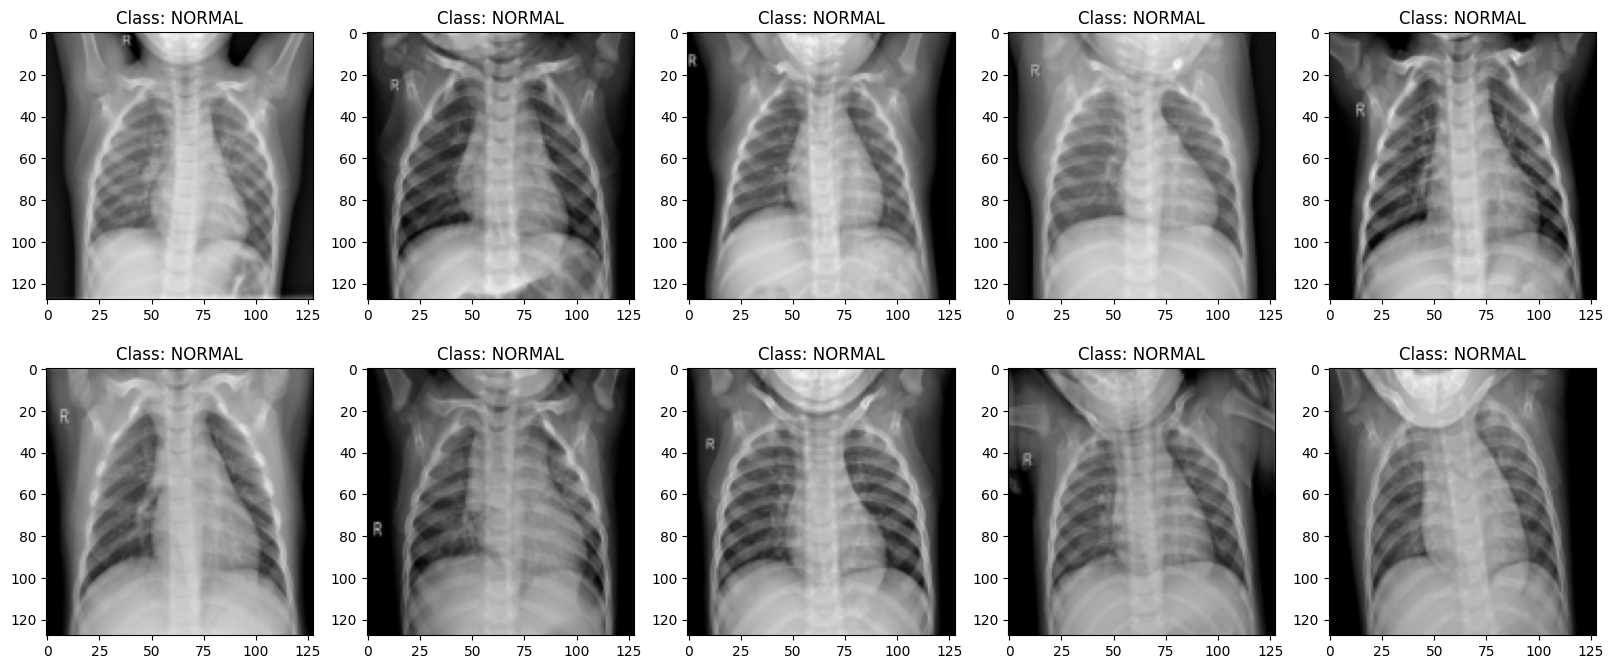

In [10]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    """ 
        Given a tensor in input this function returns the corresponding image
        This function is not necessary if in the transformations we do not apply normalization
    """
    img = tensor.numpy().transpose((1, 2, 0)) # change the order of variables in order to get (width, heigth, channels)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    return img

# access the first ten images of the train dataset and print it
fig, axis = plt.subplots(2, 5, figsize=(20, 8))
axis = axis.flatten()  # make it an array instead of a matrix
for i in range(10):
    image_tensor, img_label = image_datasets["train"][i]
    
    img = denormalize(image_tensor)
    class_name = class_names[img_label] # if 0 will be 'NORMAL', IF 1 'PNEUMONIA'
    
    axis[i].imshow(img)
    axis[i].set_title(f"Class: {class_name}")
    
    

torch.Size([32, 3, 128, 128])
32


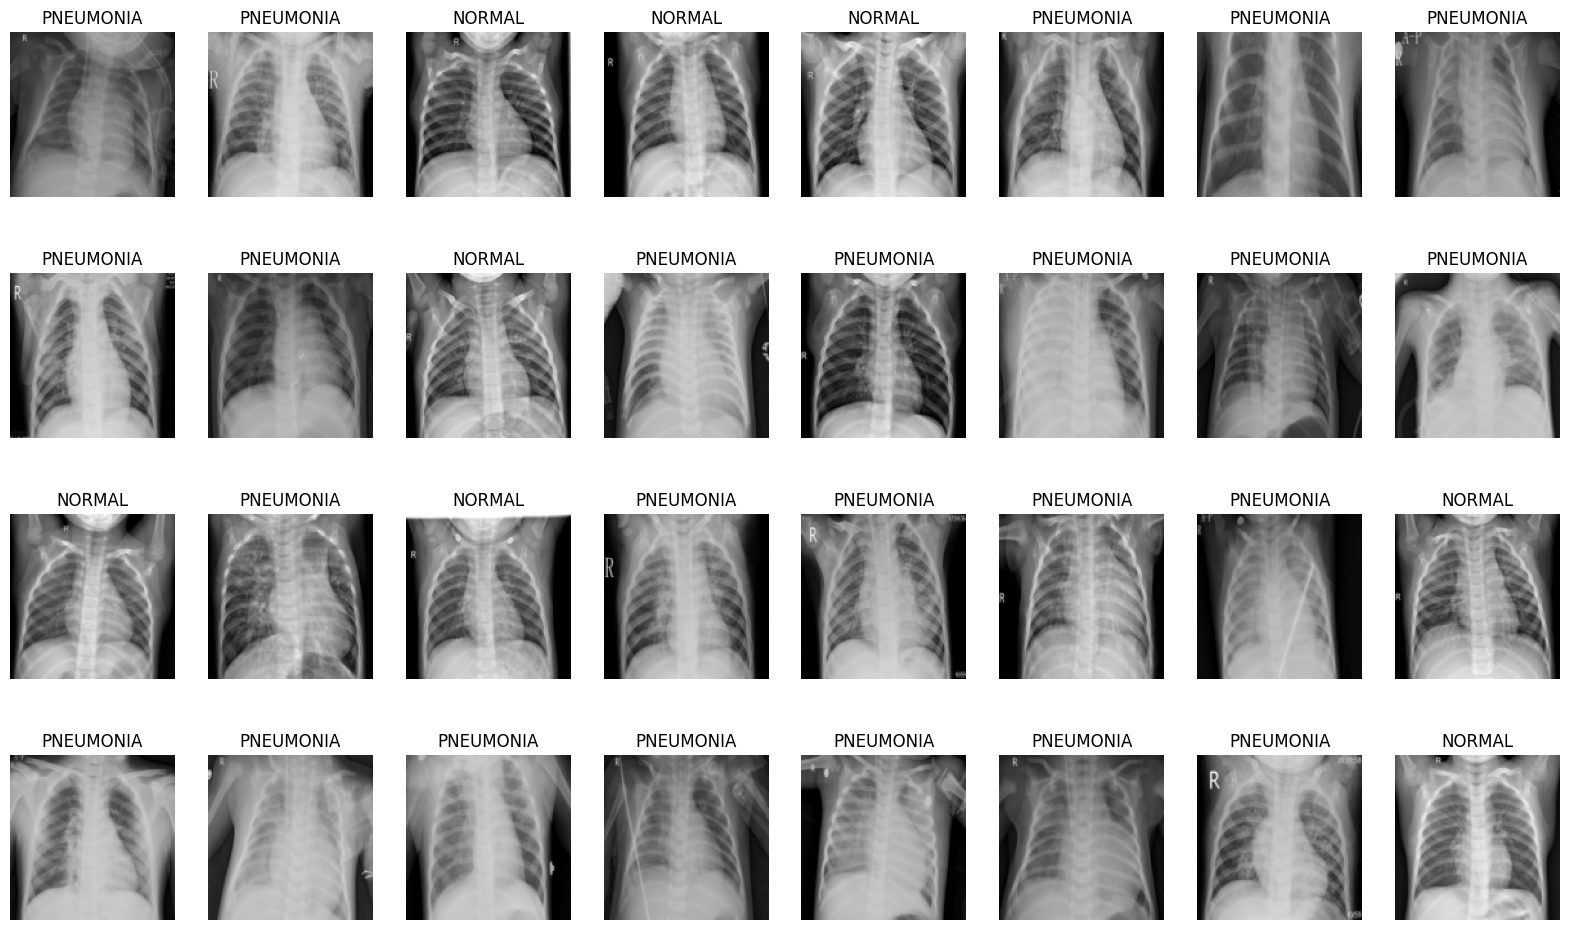

In [11]:
BATCH_SIZE = 32
# initializing dataloaders for parallel calculus with GPU
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for x in datasets_names
}
# we access images in batches with an iterator
batch_images, batch_labels = next(iter(dataloaders["train"]))

print(batch_images.shape) # prints [batches, channels, width, heigth]
print(len(batch_images))

# another plot of the images, this time shuffled (lo sto facendo solo per prenderci la mano con i plot)
fig, axs = plt.subplots(4, 8, figsize=(20,12))
axs = axs.flatten()
for i in range(BATCH_SIZE):
    img = denormalize(batch_images[i])
    label_name = class_names[batch_labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(f"{label_name}")
    axs[i].axis("off")
    

In [12]:
# here I define a list of augumentation (I just specified the most important one cited in the paper)
data_augumentations = [
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2), #setted to 20% as the paper suggest
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1))
]

# here I update the train dataset with the augumentations
data_transforms["train"] = transforms.Compose([
    transforms.Resize(RESIZE_IMG), 
    *data_augumentations, # unpack operators takes the element of the list and puts them inside another one
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
])

image_datasets["train"] = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), data_transforms["train"]) # just modify the train one

# update dataloaders with the new augmented set
dataloaders["train"] = DataLoader(image_datasets["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)



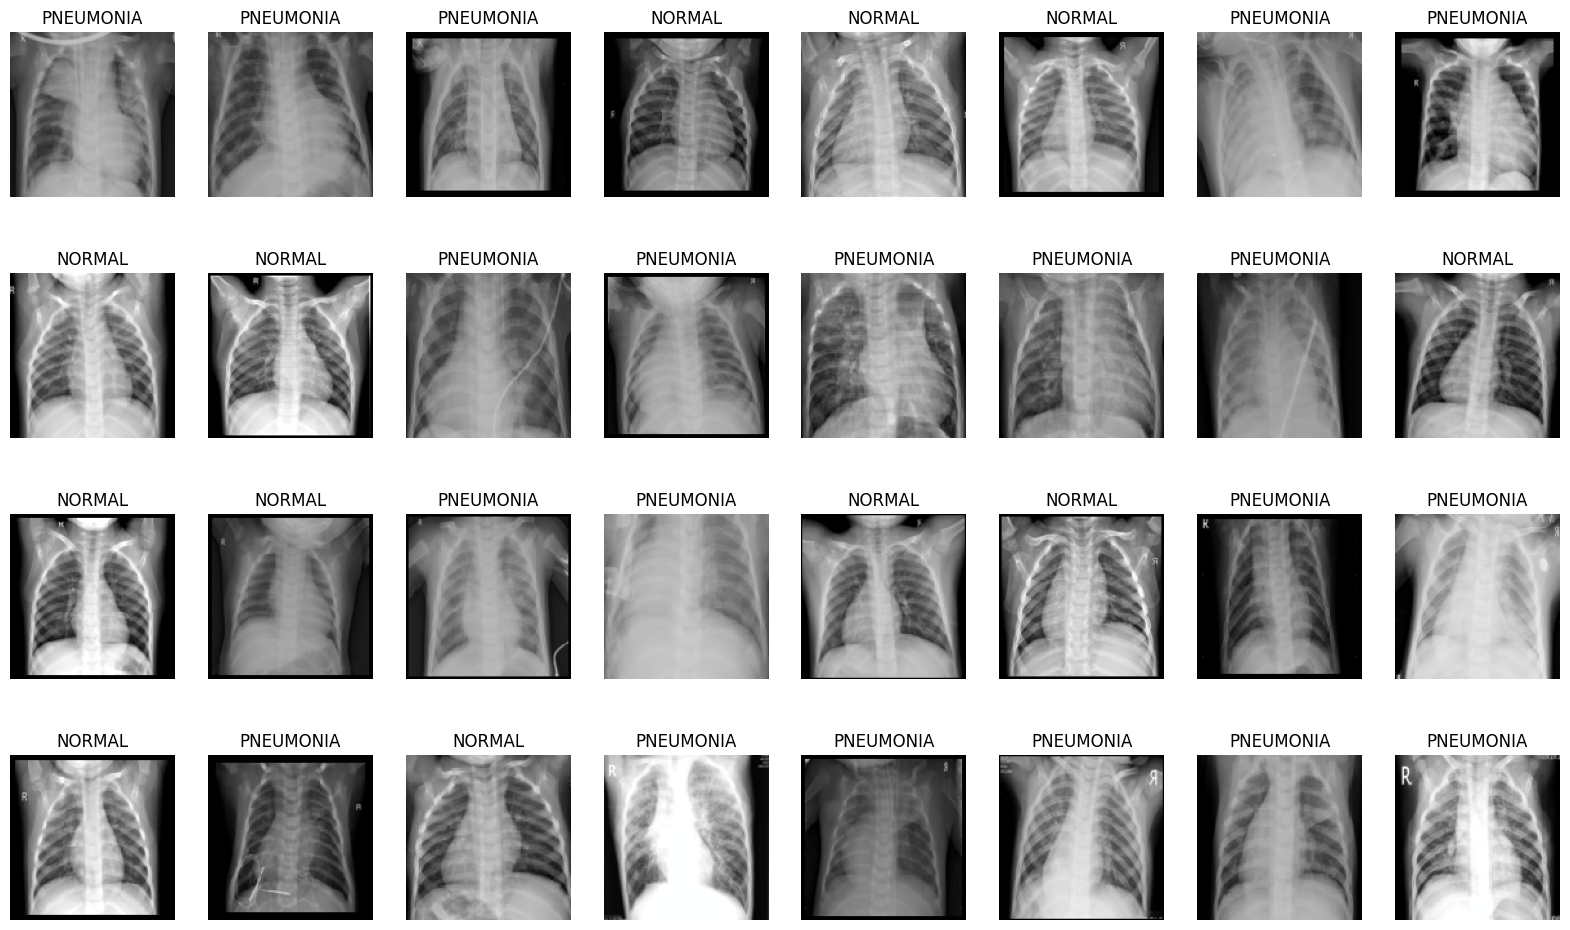

In [13]:
batch_images, batch_labels = next(iter(dataloaders["train"]))

# last images plot ( I SET THE BRIGHTEN AUGUMENTATION TO 50% JUST TO MAKE THE RESULTS VISIBLE BUT THAT HAS TO BE CHANGED TO 20%)
fig, axs = plt.subplots(4, 8, figsize=(20,12))
axs = axs.flatten()
for i in range(BATCH_SIZE):
    img = denormalize(batch_images[i])
    label_name = class_names[batch_labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(f"{label_name}")
    axs[i].axis("off")


In [14]:
#apply oversampling for class balance with SMOTE tecnique

from imblearn.over_sampling import SMOTE 
from torch.utils.data import TensorDataset

#count occurrences
train_label = image_datasets['train'].targets
count_normal = train_label.count(0)
count_pneumonia = train_label.count(1)

print(f"Count Normal: {count_normal}")
print(f"Count Pneumonia: {count_pneumonia}")

#we have to flatter images because SMOTE works with "tables" of numbers--> so we have to transform images into number vectors 

#temporary lists
train_data_flat = []
train_labels = []

for img, label in image_datasets['train']:
    train_data_flat.append(img.numpy().flatten()) #numpy transform img in array, flattern transorm it in one dim array
    train_labels.append(label)

train_data_flat = np.array(train_data_flat)
train_labels = np.array(train_labels)

print(f"Actual dimension: {train_data_flat.shape}")

smote = SMOTE(random_state=42)

img_resampled, label_resampled = smote.fit_resample(train_data_flat, train_labels) #fit resample learn from datas and make new datas similar 

print(f"Now we have: {len(label_resampled)} images.")

#check the balance
unique, counts = np.unique(label_resampled, return_counts=True)
print(counts)

#at the end we have to re-convert arrays of number in images for ur CNN

img_resampled_tensor = torch.tensor(img_resampled).float().view(-1, 3, 128, 128) 
label_resampled_tensor = torch.tensor(label_resampled).long()

train_dataset_smote = TensorDataset(img_resampled_tensor, label_resampled_tensor)

dataloaders["train"] = DataLoader(train_dataset_smote, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # save the SMOTE dataset into a DataLoader

Count Normal: 1341
Count Pneumonia: 3875
Actual dimension: (5216, 49152)
Now we have: 7750 images.
[3875 3875]


## CNN Feature Extractor

The following pipeline is a **Convolutional Neural Network Feature Extractor** built to process images and compress them.

We can see two different phases:

# 1. Spatial Feature Extractor

It consists of three repeating "Convolutional Blocks." The goal here is to learn visual patterns while reducing image dimension and increasing information density.
In particular, we apply the following blocks for 3 times:
- **Conv2D**: scans the images for features;
- **BatchNorm2D**: Normalizes values;
- **Leaky ReLU**: activation function;
- **MaxPooling**: reduces dimensions taking the highest value in a batch;

# 2. Flattening and Projection

Once the spatial features are extracted, the pipeline prepares the data for the BiGRU.

In particular we used:
- `Flatten()`: takes the (channel, width, height) tensor and creates a 1D vector;
- `Linear()`: compresses the massive flattened vector into a smaller dimension (performed two times).

In [ ]:
import torch.nn as nn

print(batch_images.shape) # print again the tensor shape

# define a sequential pipeline of operations
pipeline = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1, stride=1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.1, inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, (3, 3), padding=1, stride=1),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.1, inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2), 

    nn.Conv2d(64, 128, (3, 3), padding=1, stride=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.1, inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(), # Flatten the output when the pipeline is finished
    nn.Linear(32768, 128),
    nn.Linear(128, 64) 
)


torch.Size([32, 3, 128, 128])


# About performing the linear projection

We decided to perform linear projection of data into a smaller space *BEFORE* defining the GRU block. In the paper it is not clearly specified which input to pass the **Gated Recurrent Unit**, but working with a smaller dataset shows a much better performance and a better computational time. 

In [ ]:
device = torch.device("cuda" if gpu else "cpu") # set device for execution
pipeline.to(device)

# eval() changed the mode the BatchNorm is executed in the pipeline: ...
pipeline.eval()

features = [] # define an array that will contain all the batches

# iterate over all batches and apply the pipeline
for batch_idx, (images, labels) in enumerate(dataloaders["train"]):
    images = images.to(device) # move data to CPU/GPU
    
    with torch.no_grad():
        output = pipeline(images) # apply the pipeline to the image
    features.append(output.cpu()) #avoid gpu to overflow
    
    # print every ten batches
    if (batch_idx + 1) % 10 == 0:
        print(f"Batch n.{batch_idx + 1}: Processed.")
        
print(features[0].shape) # print the shape of the first element of features after applying the transformation

Batch n.10: Processed.
Batch n.20: Processed.
Batch n.30: Processed.
Batch n.40: Processed.
Batch n.50: Processed.
Batch n.60: Processed.
Batch n.70: Processed.
Batch n.80: Processed.
Batch n.90: Processed.
Batch n.100: Processed.
Batch n.110: Processed.
Batch n.120: Processed.
Batch n.130: Processed.
Batch n.140: Processed.
Batch n.150: Processed.
Batch n.160: Processed.
Batch n.170: Processed.
Batch n.180: Processed.
Batch n.190: Processed.
Batch n.200: Processed.
Batch n.210: Processed.
Batch n.220: Processed.
Batch n.230: Processed.
Batch n.240: Processed.
torch.Size([32, 64])


# Gated Recurrent Unit (GRU) & BiGRU

**Introduction to BiGRU**
**Recurrent Neural Networks (RNNs)** are designed to handle sequential data by maintaining a hidden state that captures information from previous time steps.
The **Bidirectional Gated Recurrent Unit (BiGRU)** is an enhancement of the standard GRU. While a standard RNN processes sequences only from start to end, a BiGRU processes data in both directions. This allows the network to capture context from both sides of a specific time step. In the context of this project, the block utilizes 2 stacked layers with a hidden size of 256.

### Mathematical Formulation

The GRU addresses the vanishing gradient problem found in traditional RNNs using gating mechanisms.

**1. Update Gate ($z_t$)**
The update gate determines how much of the past hidden state should be retained. It helps the model decide what information to carry forward.

$$
z_t = \sigma (W_z x_t + U_z h_{t-1} + b_z)
$$

* $W_z, U_z$: Weight matrices.
* $b_z$: Bias vector.
* $\sigma$: Sigmoid activation function (outputs values between 0 and 1).

**2. Reset Gate ($r_t$)**
The reset gate controls how much of the previous hidden state is forgotten, allowing the model to drop irrelevant information.

$$
r_t = \sigma (W_r x_t + U_r h_{t-1} + b_r)
$$

* $W_r, U_r, b_r$: Corresponding weights and bias for the reset gate.

**3. Candidate Hidden State ($\tilde{h}_t$)**
The candidate hidden state is computed using the reset gate to modulate the influence of the previous hidden state.

$$
\tilde{h}_t = \tanh (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
$$

* $\odot$: Element-wise multiplication (Hadamard product).
* $r_t$: The reset gate value acts as a filter on $h_{t-1}$.

In [ ]:
# define the GRU object which allows to specify the BiGRU behaviour through the 'bidirectional' parameter.
bigru = nn.GRU(
            input_size= 64,
            hidden_size= 256,
            num_layers= 2,
            dropout= 0.3,
            bidirectional=True,
            batch_first=True
        )

# update again our features in order to add the timesteps to the dataset 
for feature in features:
    # create 25 time frames of the image that will be passed to the bigru
    feature = feature.unsqueeze(1).repeat(1, 25, 1)
        
    feature, _ = bigru(feature) # each batch of tensors is passed as input to the BiGRU.
    
    # Output is supposed to be in the dimension of (batch_size, time_steps, GRU_layers*hidden_size) for each batch
    print(feature.shape)

torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([32, 25, 512])
torch.Size([